In [1]:
%matplotlib inline

# DM3 to Pandas DataFrame in heating experiments
This file is used to load DM3 data file, and create a Pandas DataFrame to store this information. We would like to store all the related DM3 information in one DataFrame.<br>

The features of DataFrame are: 'Temperature', 'Nanoflake #', 'Thickness', 'Layer', 'EELS Spectrum', 'Peak Position'
- 'Temperature', 'Nanoflake #' are from filenames, 
- 'Thickness' is from simple process, 
- 'Layer' needs to be calculated based on 'Thickness' after all the data is stored,
- 'EELS Spectrum' is a list of one principle axis in decomposition (NMF) of all the EELS in this thickness. The determination of same thickness comes from K-means clustering,
- 'Peak Position' is from the curve fitting of 'EELS Spectrum'


In [2]:
#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np
import scipy.integrate as si
import math

# basic system operation:
import os
from copy import deepcopy

# The package used for creating and manipulating HDF5 files:
import h5py
import hyperspy.api as hs

# To extract EELS ZLP, put 'eels.py' from hyperspy_tools in the python path and then import here:
from eels import extract_ZLP

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pandas as pd

# finally import pycroscopy:
import pycroscopy as px

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
center = hs.load('Center2.dm3')

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


In [63]:
# I save T150 information in 250.txt
x250, y250 = np.loadtxt('150.txt', delimiter='\t', usecols=(0, 1), unpack=True)
x150, y150 = np.loadtxt('250.txt', delimiter='\t', usecols=(0, 1), unpack=True)

Text(0.5,0,'Position (nm)')

([<matplotlib.axis.XTick at 0x1be21ef0>,
 <a list of 5 Text xticklabel objects>)

Text(0,0.5,'$E_p$ (eV)')

([<matplotlib.axis.YTick at 0x1bd9ee10>,
 <a list of 3 Text yticklabel objects>)

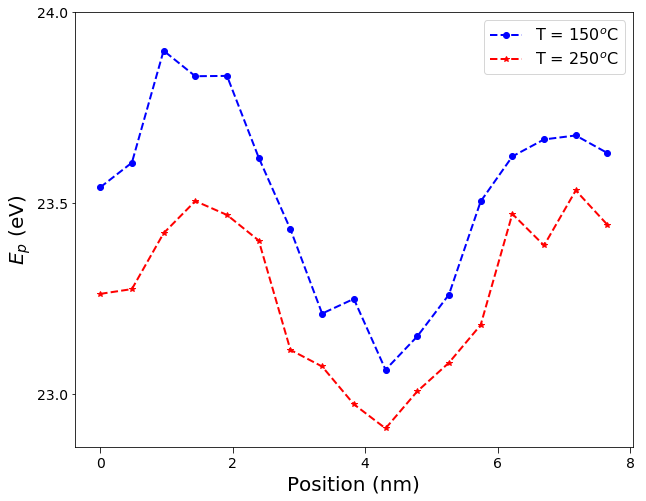

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x150,y150,'--o',color='b',label="T = 150$^o$C")
plt.plot(x250,y250,'--*',color='r',label='T = 250$^o$C')
plt.xlabel('Position (nm)', fontsize=20)
plt.xticks([0,2,4,6,8])
plt.ylabel('$E_p$ (eV)', fontsize=20)
plt.yticks([23,23.5,24])
plt.legend()
plt.savefig('line_scan.png')

[]

(array([], dtype=float64), <a list of 0 Text xticklabel objects>)

[]

(array([], dtype=float64), <a list of 0 Text yticklabel objects>)

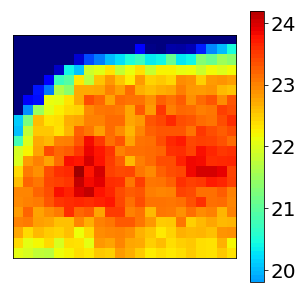

In [32]:
myim = plt.imshow(raw,cmap='jet',extent=[0,1,0,1],interpolation='nearest',vmin=18,vmax=24.5)
cbar = plt.colorbar(ticks=[20,21,22,23,24],boundaries=np.linspace(19.8,24.2,70))
cbar.xlim=[19,25]
cbar.ax.tick_params(labelsize=20) 
plt.gca().set_xticks([])
plt.xticks()
plt.gca().set_yticks([])
plt.yticks()

plt.savefig('center.png')

## Create Pandas DataFrame to store all the data

In [3]:
# Create Pandas DataFrame
tmd = pd.DataFrame(columns=['Temperature', 'Nanoflake_Number', 'Thickness', 'Thickness_List', 'Layer', 'Spectrum_Axis', 'EELS_Spectrum', 'Peak_Position'])
temp_list = [150,250,350]
nflake_list = [1,2,3,3.5,4,5,6,7,8,9,10,11]
cluster_list = [2,2,2,2,2,7,4,3,4,4,2,2]
weight = 5

#define a function to return the k number for Kmeans clustering of thickness
def get_k_number(a):
    for i in range(1,6):
        estimator = KMeans(n_clusters=i);#构造聚类器
        estimator.fit(a)#聚类
        if estimator.inertia_ < 0.15: # 获取聚类准则的总和
            return i
    if  estimator.inertia_ >= 0.15:
        return 5
    

#define a function to give a new feature of thickness, variance:
def get_t_variance(tmat):
    num_rows = np.shape(tmat)[0]
    num_cols = np.shape(tmat)[1]
    stdmat = np.zeros((num_rows-2,num_cols-2))
    for i in range(1,num_rows-1):
        for j in range(1,num_cols-1):
            row = np.array([[i-1,i,i+1]]).astype(int)
            col = np.array([[j-1,j,j+1]]).astype(int)
            rowmat = np.transpose(np.dot(np.ones((3,1)).astype(int),row))
            colmat = np.dot(np.ones((3,1)).astype(int),col)
            test = np.reshape(tmat[rowmat,colmat],(-1))
            stdmat[i-1,j-1] = np.std(test)
    return stdmat

def get_thickness(raw,zlp):
    new_axes = raw.axes_manager['Energy loss']
    x0 = np.linspace(new_axes.offset, new_axes.offset+new_axes.scale*(new_axes.size-1), new_axes.size)
    th=lograt_mat(raw,zlp,x0)
    return th
    
def lograt(r0,z0,x0):
    t0 = si.simps(z0,x0)
    t1 = si.simps(r0,x0)
    return math.log(t1/t0)

def lograt_mat(raw,zlp,x0):
    thick = np.ones(np.shape(raw)[0:2])
    for i in range(np.shape(raw)[0]):
        for j in range(np.shape(raw)[1]):
            r0 = raw.data[i,j,:]
            z0 = zlp.data[i,j,:]
            thick[i,j]=lograt(r0,z0,x0)
    return thick

def getindex(number,data_shape):
    id1 = number//(data_shape[1])
    id2 = number%(data_shape[1])
    return (id1,id2)

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\Lib\Xuan\eels.py:151: RuntimeWarning: invalid value encountered in less
  inelastic.data[inelastic.data < 0] = 0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

1

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


1

NotImplementedError: Currently we only support reading DM versions 3 and 4 but this file seems to be version -1991752634 

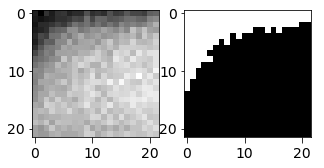

In [10]:
# start 'for' loop to load and process the data
folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
for t in temp_list:
    for fl in nflake_list:
        if t == temp_list[-1] and fl == nflake_list[-1]:
            break
        #load the data
        folder_name = str(t) + '_' + str(fl)
        file_name = folder_path + folder_name + '/EELS Spectrum Image.dm4'
        raw = hs.load(file_name,signal_type='EELS')
        
        #general process:alignment, thickness, zlp substraction
        num_rows = np.shape(raw.data)[0]
        num_cols = np.shape(raw.data)[1]
        raw.align_zero_loss_peak(subpixel=True,show_progressbar=None,print_stats=False)
        
        
        try:
            zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)
        except OverflowError:
            raw = raw/10
            zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)
        
        
        new_axes = sig.axes_manager['Energy loss']
        x0 = np.linspace(new_axes.offset, new_axes.offset+new_axes.scale*(new_axes.size-1), new_axes.size)
        thickmat = get_thickness(raw,zlp)
                
        sig_data = np.reshape(sig.data,(-1,sig.data.shape[2]))
        sig_data[np.isnan(sig_data)] = 0
        
        #for i in range(np.shape(sig_data)[0]):
        #    temp_data = deepcopy(sig_data[i,:])
        #    temp_data[np.isnan(temp_data)] = 0
        #    sig_data[i,:] = deepcopy(temp_data)
            
        
        #divide the data into clusters based on the thickness by k-means
        sp = np.shape(thickmat)
        task = []
        for i in range(sp[0]):
            for j in range(sp[1]):
                task.append([i,j,thickmat[i,j]])
        t1=np.array(task)

        t1[np.isnan(t1)]=0
        t2=normalize(t1,axis=0)
        t3=deepcopy(t2)
        t3[:,2]=t3[:,2]*weight

        #num_clusters = get_k_number(task)
        num_clusters = cluster_list[nflake_list.index(fl)]
        estimator = KMeans(n_clusters=num_clusters)#构造聚类器
        estimator.fit(t3)#聚类
        label_pred = estimator.labels_ #获取聚类标签
        centroids = estimator.cluster_centers_ #获取聚类中心
        #print('KMeans error: ',estimator.inertia_) # 获取聚类准则的总和
        
        #test clustering
        plt.subplot(1,2,1)
        plt.imshow(thickmat)
        plt.subplot(1,2,2)
        lb=np.reshape(label_pred,np.shape(thickmat))
        plt.imshow(lb)
        ulabel = np.unique(label_pred)
        take_num = 0
        for im in ulabel:
            if centroids[im,2] == min(centroids[:,2]):
                take_num = im
        label_num = list(range(num_clusters))
        label_num.pop(take_num)
        for i in label_num:
            sig_temp = sig_data[label_pred == i, :]
            thick_val = np.mean(t1[label_pred == i, 2])
            model = NMF(n_components=4, init='random', random_state=0)
            W = model.fit_transform(sig_temp)
            H = model.components_
            spec = H[0,:]
            
            tmd = tmd.append({'Temperature': t,
                             'Nanoflake_Number': fl,
                             'Thickness': thick_val,
                             'Thickness_List': list(t1[label_pred == i, 2]),
                             'Spectrum_Axis': x0,
                             'EELS_Spectrum': list(spec)}, ignore_index=True)

In [48]:
tmd.to_csv(folder_path+'/TMD_new.csv')

In [42]:
tmd = pd.DataFrame(columns=['Temperature', 'Nanoflake_Number', 'Thickness', 'Layer', 'EELS_Spectrum', 'Peak_Position'])

(array([ 4.,  5., 10.,  7.,  3.,  3.,  4.,  5.,  1.,  0.,  4.,  1.,  1.,
         0.,  2.,  0.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  0.,  0.,  2.,
         0.,  3.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.03369653, 0.03962061, 0.04554468, 0.05146875, 0.05739282,
        0.06331689, 0.06924096, 0.07516503, 0.08108911, 0.08701318,
        0.09293725, 0.09886132, 0.10478539, 0.11070946, 0.11663353,
        0.12255761, 0.12848168, 0.13440575, 0.14032982, 0.14625389,
        0.15217796, 0.15810203, 0.16402611, 0.16995018, 0.17587425,
        0.18179832, 0.18772239, 0.19364646, 0.19957053, 0.2054946 ,
        0.21141868, 0.21734275, 0.22326682, 0.22919089, 0.23511496,
        0.24103903, 0.2469631 , 0.25288718, 0.25881125, 0.26473532,
        0.27065939, 0.27658346, 0.28250753, 0.2884316 , 0.29435568,
        0.30027975, 0.30620382, 0.31212789, 0.31805196, 0.32397603,
        0.3299001 ]),
 <a list of 50

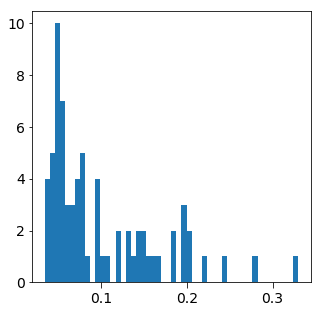

In [31]:
ind, plt.hist(tmd['Thickness'],50)

In [6]:
tmd

,Temperature,Nanoflake_Number,Thickness,Thickness_List,Layer,Spectrum_Axis,EELS_Spectrum,Peak_Position
0,150,1,0.051779,"[0.04964418256944714, 0.05025928332922756, 0.0...",NaN,"[-10.611673711845267, -10.561673711100209, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
1,150,2,0.051953,"[0.04008605391897694, 0.04153889935995845, 0.0...",NaN,"[-10.564876190486771, -10.514876189741713, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,150,3,0.051799,"[0.036499892053164236, 0.03700958004260841, 0....",NaN,"[-10.548553876193964, -10.498553875448906, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
3,150,3.5,0.052271,"[0.037202066101265564, 0.03860911272269586, 0....",NaN,"[-10.613533216005207, -10.563533215260149, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
4,150,4,0.049739,"[0.04412852450012425, 0.04557972751704245, 0.0...",NaN,"[-10.951852015047162, -10.901852014302104, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
5,150,5,0.157282,"[0.14879464363892514, 0.15226728761238875, 0.1...",NaN,"[-10.182500151731073, -10.132500150986015, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
6,150,5,0.055273,"[0.06599271046914475, 0.05907118794274354, 0.0...",NaN,"[-10.182500151731073, -10.132500150986015, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
7,150,5,0.034734,"[0.03950695348725538, 0.036343847738604065, 0....",NaN,"[-10.182500151731073, -10.132500150986015, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
8,150,5,0.120578,"[0.13486726993454, 0.12202916798542426, 0.1201...",NaN,"[-10.182500151731073, -10.132500150986015, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
9,150,5,0.079299,"[0.09432813224530383, 0.08776116700366823, 0.0...",NaN,"[-10.182500151731073, -10.132500150986015, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN


In [8]:
tmdlist = [isimn for isim in tmd['Thickness_List'] for isimn in isim]

(array([ 651.,  803., 1013., 1088.,  909.,  702.,  471.,  432.,  343.,
         234.,  224.,  172.,  183.,  147.,  134.,  128.,  131.,  131.,
         105.,   98.,   82.,   99.,  103.,   81.,   61.,   66.,   51.,
          59.,   87.,   79.,   99.,   78.,   67.,   58.,   59.,   52.,
          58.,   52.,   44.,   44.,   34.,   43.,   27.,   26.,   24.,
          26.,   23.,   23.,   14.,   29.]),
 array([0.04  , 0.0432, 0.0464, 0.0496, 0.0528, 0.056 , 0.0592, 0.0624,
        0.0656, 0.0688, 0.072 , 0.0752, 0.0784, 0.0816, 0.0848, 0.088 ,
        0.0912, 0.0944, 0.0976, 0.1008, 0.104 , 0.1072, 0.1104, 0.1136,
        0.1168, 0.12  , 0.1232, 0.1264, 0.1296, 0.1328, 0.136 , 0.1392,
        0.1424, 0.1456, 0.1488, 0.152 , 0.1552, 0.1584, 0.1616, 0.1648,
        0.168 , 0.1712, 0.1744, 0.1776, 0.1808, 0.184 , 0.1872, 0.1904,
        0.1936, 0.1968, 0.2   ]),
 <a list of 50 Patch objects>)

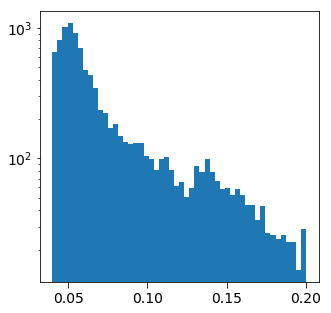

In [9]:
plt.hist(tmdlist,50,(0.04,0.2))
plt.yscale('log', nonposy='clip')

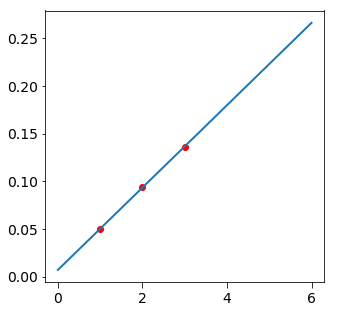

In [179]:
a=[0.0496, 0.0944, 0.136]
b=[1,2,3]
thick_eff=np.polyfit(b,a,1)
xa=np.linspace(0,6,100)
plt.plot(xa,thick_eff[0]*xa+thick_eff[1])
plt.scatter(b,a,color='r')

In [180]:
tmd['Layer']=(tmd['Thickness']-thick_eff[1])/thick_eff[0]

In [189]:
result=pd.DataFrame(index=tmd[tmd['Temperature'] == 150].index,columns=['Nanoflake_Number','Layer','Peak_Position','Temperature_List','Shift','Normalized_Shift'])

In [ ]:
for ifl in tmd[tmd['Temperature'] == 150].index:
    resulttmd['Peak_Position'][tmd['Nanoflake_Number'] == ifl]

In [10]:
pp1 = tmd['Peak_Position'][tmd['Temperature'] == 150]
pp2 = tmd['Peak_Position'][tmd['Temperature'] == 250]
pp3 = tmd['Peak_Position'][tmd['Temperature'] == 350]

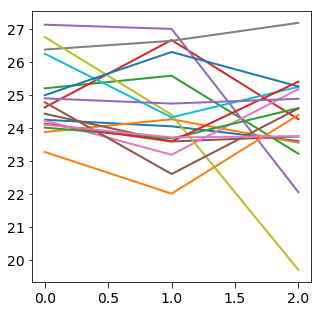

In [266]:
for ip in range(np.shape(ppr2)[0]):
    plt.plot(ppr2[ip,:])

In [217]:
ppr = np.vstack((pp1,pp2,pp3))
ppr = np.transpose(ppr)

In [11]:
from scipy.optimize import curve_fit
def gauss(x, a, b, c, d): return a*np.exp(-((x-b)/c)**2) + d;

def gauss_fit(x0,y0,rg):
    offset = x0[0]
    scale = (x0[-1]-x0[0])/(np.shape(x0)[0]-1)
    a4 = min(y0);
    def FWHM(X,Y):
        half_max = max(Y) / 2.
        d = Y - half_max
        indx = np.where(d > 0)
        return abs(X[indx][-1] - X[indx][0])
    a3 = FWHM(x0,np.array(y0))/2.35;
    #a3 = ((max(x0)-min(x0))/10)**2;
    a1 = max(y0)-min(y0);
    a2 = (rg[0]+rg[1])/2;
    ind = np.round((rg-offset)/scale).astype('int')
    x1 = x0[ind[0]:ind[1]]
    y1 = y0[ind[0]:ind[1]]

    pg, pgv = curve_fit(gauss, x1, y1, [a1, a2, a3, a4],maxfev=5000)
    return pg[1]
    
rg=[20,30]
#def find_rg(X,Y):
#    d = Y - max(Y)/2
#    indx = np.where(d > 0)
#    return [X[indx][0],X[indx][-1]]

for icase in tmd.index:
    x0 = tmd['Spectrum_Axis'][icase]
    y0 = tmd['EELS_Spectrum'][icase]
    try:
        tmd['Peak_Position'][icase] = gauss_fit(x0,y0,rg)
    except RuntimeError:
        tmd['Peak_Position'][icase] = 0
    

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
half_max = max(np.array(y0)) / 2
d = y0 - half_max
ind = np.where(d > 0)

In [166]:
for ifl in nflake_list:
    tmd['Peak_Position'][tmd['Nanoflake_Number'] == ifl]

,Temperature,Nanoflake_Number,Thickness,Thickness_List,Layer,Spectrum_Axis,EELS_Spectrum,Peak_Position
0,150,1,0.051779,"[0.04964418256944714, 0.05025928332922756, 0.0...",NaN,"[-10.611673711845267, -10.561673711100209, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.194752
24,250,1,0.046052,"[0.03823848930472759, 0.04036575383059291, 0.0...",NaN,"[-10.423140651184665, -10.373140650439607, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24.864017
48,350,1,0.055125,"[0.05250048358583511, 0.053500541448039694, 0....",NaN,"[-10.078202629515763, -10.028202628770705, -9....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000


In [ ]:
tmd[]

In [170]:
tmd['Peak_Position'][tmd['Nanoflake_Number'] == 1]

0     25.194752
24    24.864017
48     0.000000
Name: Peak_Position, dtype: float64

In [162]:
pg, pgv = curve_fit(gauss, x0, y0, [a1, a2, a3, a4],maxfev=5000)

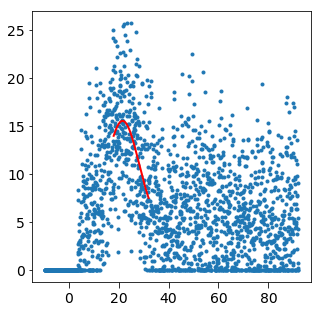

In [163]:
plt.scatter(x0,y0,marker='.')
xg = np.linspace(rg[0], rg[1], new_axes.size*10)
plt.plot(xg,gauss(xg,pg[0],pg[1],pg[2],pg[3]),'r')
    

In [7]:
## Save the DataFrame
store = pd.HDFStore(folder_path +'/TMD_new.h5')

store['TMD'] = tmd  # save it

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['Temperature', 'Nanoflake_Number', 'EELS_Spectrum']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
hdf = px.ioHDF5(folder_path + folder_name +'/TMD.h5')
h5_file = hdf.file

print('Contents of data file:')
print('----------------------')
px.hdf_utils.print_tree(h5_file)
print('----------------------')

In [7]:
t=150
fl=5
folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
folder_name = str(t) + '_' + str(fl)
file_name = folder_path + folder_name + '/EELS Spectrum Image.dm4'
raw = hs.load(file_name,signal_type='EELS')

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


In [4]:
folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
file_name = folder_path + 'thickness_150_3.dm4'
print(file_name)
thickmat = hs.load(file_name)

D:/Books/research/IMAGE/20180110_TMD/thickness_150_3.dm4


D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

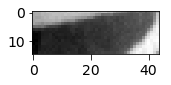

In [8]:
raw.align_zero_loss_peak(subpixel=True,show_progressbar=None,print_stats=False)

for isim in range(3):
    try:
        zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)
    except OverflowError:
        raw = raw/10
        zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)
    if sum(sum(np.sum(np.isnan(sig.data),axis=2))) < 8:
        break

thickmat = get_thickness(raw,zlp)

sig_data = np.reshape(sig.data,(-1,sig.data.shape[2]))
sig_data[np.isnan(sig_data)] = 0
plt.subplot(1,2,1)
plt.imshow(thickmat)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

(<matplotlib.figure.Figure at 0x19cb1fd0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019C5E8D0>,
       dtype=object))

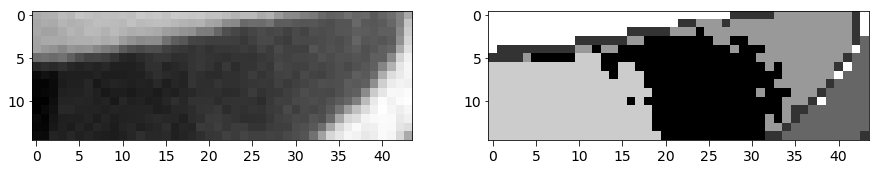

In [9]:
#divide the data into clusters based on kmeans the thickness
sp = np.shape(thickmat)
task = []
for i in range(sp[0]):
    for j in range(sp[1]):
        task.append([i,j,thickmat[i,j]])
t=np.array(task)

t[np.isnan(t)]=0
t2=normalize(t,axis=0)
t3=deepcopy(t2)
t3[:,2]=t3[:,2]*4

#num_clusters = get_k_number(task)
num_clusters = 6
estimator = KMeans(n_clusters=num_clusters)#构造聚类器
estimator.fit(t3)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
#print('KMeans error: ',estimator.inertia_) # 获取聚类准则的总和

#test clustering
plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(thickmat)
plt.subplot(1,2,2)
lb=np.reshape(label_pred,np.shape(thickmat))
plt.imshow(lb)

In [26]:
import scipy.integrate as si

In [135]:
zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):
D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\Lib\Xuan\eels.py:151: RuntimeWarning: invalid value encountered in less
  inelastic.data[inelastic.data < 0] = 0


In [31]:
z0 = zlp.data[0,0,:]
r0 = raw.data[0,0,:]
print(z0)

[ 214.58952491  234.05152262  275.89404409 ...  -42.17545529 -123.14618029
 -156.58046418]


In [17]:
%matplotlib inline

In [37]:
def lograt(r0,z0,x0):
    t0 = si.simps(z0,x0)
    t1 = si.simps(r0,x0)
    return math.log(t1/t0)

In [46]:
def lograt_mat(raw,zlp,x0):
    thick = np.ones(np.shape(raw)[0:2])
    for i in range(np.shape(raw)[0]):
        for j in range(np.shape(raw)[1]):
            r0 = raw.data[i,j,:]
            z0 = zlp.data[i,j,:]
            thick[i,j]=lograt(r0,z0,x0)
    return thick

In [138]:
np.shape(x0)

(2033,)

In [139]:
new_axes = raw.axes_manager['Energy loss']
x0 = np.linspace(new_axes.offset, new_axes.offset+new_axes.scale*(new_axes.size-1), new_axes.size)
th=lograt_mat(raw,zlp,x0)

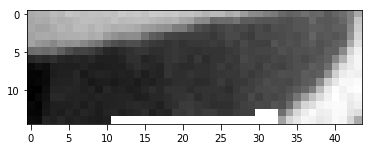

In [140]:
plt.imshow(th)

In [53]:
def getindex(number,data_shape):
    id1 = number//(data_shape[1])
    id2 = number%(data_shape[1])
    return (id1,id2)

In [210]:
sp = np.shape(th)
task = []
for i in range(sp[0]):
    for j in range(sp[1]):
        task.append([i,j,th[i,j]])
t=np.array(task)

In [211]:
t[np.isnan(t)]=0
t2=normalize(t,axis=0)

In [188]:
from sklearn import preprocessing
ts = preprocessing.scale(t)

In [194]:
from skimage.filters import sobel
from skimage.morphology import watershed
elevation_map = sobel(th)

In [269]:
elevation_map[1]

array([0.        , 0.00628661, 0.01000932, 0.00878695, 0.00621744,
       0.00842881, 0.00623491, 0.00414671, 0.00526201, 0.00556569,
       0.00763648, 0.01134952, 0.01377074, 0.01531775, 0.01791521,
       0.02250773, 0.02767116, 0.03095942, 0.03452303, 0.04033501,
       0.04556038, 0.05474318, 0.06241111, 0.06661327, 0.06921901,
       0.06604867, 0.06097254, 0.05795283, 0.05170378, 0.04270499,
       0.03848158, 0.03349239, 0.02606167, 0.01852373, 0.01200386,
       0.01189599, 0.0128543 , 0.00806757, 0.00917298, 0.00315636,
       0.00905738, 0.02088011, 0.05286701, 0.        ])

In [264]:
t2[:,2]=t2[:,2]/6

In [266]:
err=[]
for i in range(10):
    t3=deepcopy(t2)
    t3[:,2]=t3[:,2]*i
    estimator.fit(t3)
    err.append(estimator.inertia_)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

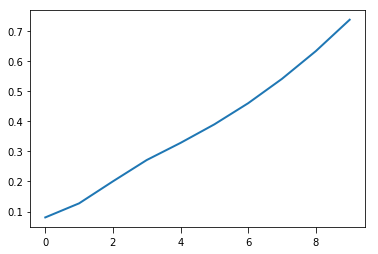

In [268]:
plt.plot(range(10),err)

In [283]:
estimator = KMeans(n_clusters=7, init='k-means++', n_init=50, max_iter=3000, 
                   tol=0.0001, precompute_distances=True, verbose=0, random_state=None, 
                   copy_x=True, n_jobs=1, algorithm='full')

In [291]:
file_name

'H:/20180110_TMD/150_5/EELS Spectrum Image.dm4'

In [289]:
t3=deepcopy(t2)
t3[:,2]=t3[:,2]*4
estimator.fit(t3)
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=7, n_init=50, n_jobs=1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

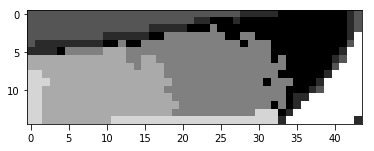

In [290]:
lb=np.reshape(label_pred,np.shape(th))
plt.imshow(lb)

In [102]:
t3

array([[0.        , 0.        , 0.29012546],
       [0.        , 0.00155887, 0.29711087],
       [0.        , 0.00311774, 0.29990173],
       ...,
       [0.06624738, 0.06391366, 0.40960236],
       [0.06624738, 0.06547253, 0.3616219 ],
       [0.06624738, 0.0670314 , 0.28817023]])

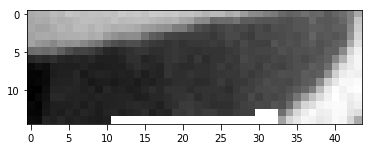

In [155]:
plt.imshow(th)

In [165]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2

In [170]:
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

In [176]:
from sklearn.feature_extraction import image
# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

In [179]:
type(img)

numpy.ndarray

In [318]:
sig_data = np.reshape(sig.data,(-1,sig.data.shape[2]))

In [327]:
zlp, sig = extract_ZLP(raw,range_factor=(-10, 8),return_inelastic=True,print_output=False)

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):
D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

D:\Anaconda3\Lib\Xuan\eels.py:151: RuntimeWarning: invalid value encountered in less
  inelastic.data[inelastic.data < 0] = 0


In [340]:
np.sum(np.isnan(sig.data),axis=2)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       